# NYC Taxi

By: Rodrigo Hernández Mota

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import quanta as mx

from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# Evaluation function

def rmsle(predicted, real):
    """Root mean square logarithmic error."""
    rsum = 0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        rsum = rsum + (p - r)**2
    return (rsum/len(predicted))**0.5

In [3]:
# Linear Regression

def getCoefs(x, y):
    x = np.asmatrix(x.values)
    y = np.asmatrix(y.values)
    return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)


liniarReg = lambda x: np.asmatrix(x.values).dot(coefs)

## Auxiliar functions

In [4]:
def oneHotEncoding(x, labels):
    """Return a pandas series with one-hot encoding."""
    def oneHot(x):
        return x == np.asarray(labels)
    return pd.Series(oneHot(x), labels)


def degree2radian(degree):
    """Get rads from a degree."""
    return 2 * degree * np.pi / 360


def harversine(initialCoord, finalCoord):
    """Get distance between two coords."""
    r = 6371
    initialRads = list(map(degree2radian, initialCoord))
    finalRads = list(map(degree2radian, finalCoord))
    deltaPhi = finalRads[0] - initialRads[0]
    deltaLambda = initialRads[1] - finalRads[1]
    h = np.power(np.sin(deltaPhi/2), 2) + \
        np.cos(initialRads[0]) * np.cos(finalRads[0]) * \
        np.power(np.sin(deltaLambda/2), 2)
    return 2*r*np.arcsin(np.sqrt(h))


def logTrasnf(vector):
    """Retrun logarithmic transform."""
    return list(map(np.log, vector))


def invLogTransf(vector):
    """Return the inverse log transform."""
    return list(map(np.exp, vector))


In [5]:
# Normalize

def meanDesnorm(value, dataset):
    """."""
    mu_y, std_y = dataset.mu_y, dataset.std_y
    value = value * std_y + mu_y
    return np.asscalar(value)


def minmaxDesnorm(value, dataset):
    """."""
    _min, _max = dataset.min_y, dataset.max_y
    value = (_max-_min)*value + _min
    return np.asscalar(value)


def desnormalize(value, dataset, kind="mean"):
    """."""
    return meanDesnorm(value, dataset) if ("mean" in kind) \
        else minmaxDesnorm(value, dataset)


def normalizeExternalData(vector, dataset, kind="mean"):
    """."""
    vector = np.asarray(vector)
    if ("mean" in kind):
        mu_x, std_x = dataset.mu_x, dataset.std_x
        return (vector - mu_x) / std_x
    else:
        _min, _max = dataset.min_x, dataset.max_x
        return (vector-_min) / (_max-_min)

## Data Exploration

### Load 

In [6]:
test = pd.read_csv("data/test.csv")#.sample(frac=0.7)
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')

In [3]:
train = pd.read_csv("data/train.csv")#.sample(frac=0.7)
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
train.shape

(1458644, 11)

### Geo-coords

In [8]:
mean_pickup_position = train[["pickup_latitude", "pickup_longitude"]].mean()
mean_pickup_position

pickup_latitude     40.750921
pickup_longitude   -73.973486
dtype: float64

In [9]:
mean_dropoff_position = train[["dropoff_latitude", "dropoff_longitude"]].mean()
mean_dropoff_position

dropoff_latitude     40.751800
dropoff_longitude   -73.973416
dtype: float64

In [10]:
mean_coords = pd.DataFrame([mean_pickup_position.values, mean_dropoff_position.values]).mean().values
mean_coords

array([ 40.75136021, -73.97345113])

In [11]:
distance_to_center = train.apply(lambda x: (harversine([x.pickup_latitude, x.pickup_longitude], mean_coords) + \
                                 harversine([x.dropoff_latitude, x.dropoff_longitude], mean_coords))/2, 1).to_frame()

distance_to_center.columns = ["distance"]
distance_to_center.describe()

,distance
count,1.458644e+06
mean,3.322411e+00
std,5.951139e+00
min,2.279319e-02
25%,1.804547e+00
50%,2.635289e+00
75%,3.857189e+00
max,4.105645e+03


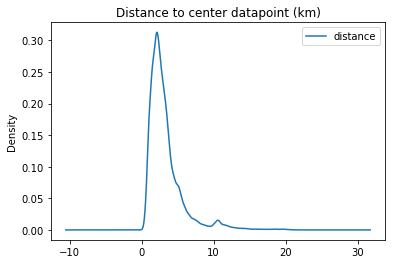

In [12]:
# Filter distance to center
temp = distance_to_center.describe()
_index = distance_to_center.apply(lambda x: x < (np.asscalar(temp.loc["mean"]) + \
                                                 3 * np.asscalar(temp.loc["std"])), 1).values

# Distance to center distribution
distance_to_center[_index].plot(kind="kde")
plt.title('Distance to center datapoint (km)')
plt.show()

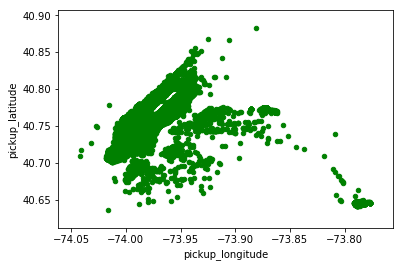

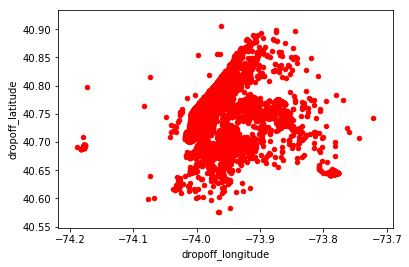

In [12]:
# PLOT DATAPOINTS

# Pickup
train[_index].plot.scatter("pickup_longitude", "pickup_latitude", c='g')
plt.show()

# Dropoff
train[_index].plot.scatter("dropoff_longitude", "dropoff_latitude", c='r')
plt.show()

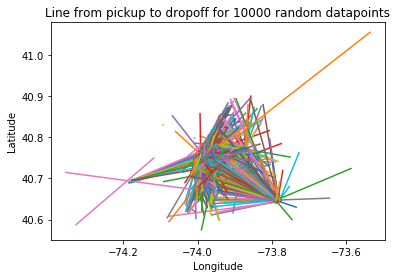

In [13]:
# From Pickup to Dropoff plot
n_elements = 10000
cols = ["pickup_longitude", "dropoff_longitude", "pickup_latitude", "dropoff_latitude"]
vals = test[_index][cols].values
desired_elements = np.random.randint(0,len(vals),n_elements)

for i in [vals[j] for j in range(len(vals)) if j in desired_elements]:
    x = i[:2]
    y = i[-2:]
    plt.plot(x,y)
plt.title('Line from pickup to dropoff for {} random datapoints'.format(n_elements))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [13]:
def getLatLngKmeans(df):
    nclusters = 100
    batch = 10000
    kmeans = MiniBatchKMeans(n_clusters=nclusters, batch_size=batch).fit(
        df[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].sample(frac=0.7))
    return kmeans
    

In [14]:
def addLatLngClusters(df):
    kmeans = getLatLngKmeans(df.sample(frac=0.7))
    clusters_pickup = kmeans.predict(df[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]])
    clusters_onehot = pd.DataFrame({"clusters": clusters_pickup}).apply(lambda x: oneHotEncoding(x.clusters, list(range(100))), 1)
    clusters_onehot.columns = ["cluster_" + str(c) for c in clusters_onehot.columns]
    return pd.concat([df, clusters_onehot], axis=1)

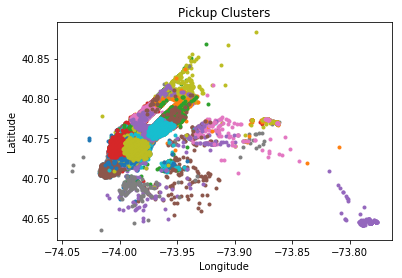

In [307]:
nclusters = 100
batch = 10000
kmeans = getLatLngKmeans(train[_index].sample(frac=0.7))
clusters_pickup = kmeans.predict(train[_index][["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]])


for i in range(100):
    temp_index = clusters_pickup == i
    temp_df = train[_index][["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]][temp_index]
    plt.plot(temp_df.pickup_longitude, temp_df.pickup_latitude, '.')
plt.title("Pickup Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [56]:
clusters_onehot = pd.DataFrame({"clusters": clusters_pickup}).apply(lambda x: oneHotEncoding(x.clusters, list(range(100))), 1)
clusters_onehot.columns = ["cluster_" + str(c) for c in clusters_onehot.columns]

### Weekdays 

In [15]:
raw_weekdays = [0, 1, 2, 3, 4, 5, 6]
weekday_labels = {
    0: "monday",
    1: "tuesday",
    2: "wednesday",
    3: "thursday",
    4: "friday",
    5: "saturday",
    6: "sunday"
    }

weekdays = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]

def getDatetime(string):
    """Return datetime variable given a string."""
    return dt.datetime.strptime(string, "%Y-%m-%d %H:%M:%S")


def getWeekDay(date):
    """Given a datetime, return a weekday."""
    return date.weekday()


def getHour(date):
    """Given a datetime, return hour."""
    return date.hour


def addWeekday(df):
    """Add weekday columns."""
    temp = df.apply(lambda x: oneHotEncoding(
                getWeekDay(getDatetime(x.pickup_datetime)), raw_weekdays), 1)
    temp.columns = [weekday_labels[c] for c in temp.columns]
    return pd.concat([df, temp], axis=1)


def addHour(df):
    """Add hour column."""
    df["hour"] = df.apply(lambda x: getHour(getDatetime(
                                                x.pickup_datetime)), 1).values
    return df



### Distance

In [17]:
def addDistance(df, log=True):
    """Add distance col."""
    f = (lambda x: np.log(x + 0.00001)) if log else (lambda x: x)
    df["log_distance"] = df.apply(lambda x: f(harversine(
                        [x.pickup_latitude, x.pickup_longitude],
                        [x.dropoff_latitude, x.dropoff_longitude])), 1).values
    df["distance"] = df.apply(lambda x: harversine(
                        [x.pickup_latitude, x.pickup_longitude],
                        [x.dropoff_latitude, x.dropoff_longitude]), 1).values
    df['distance_to_center'] = df.apply(lambda x: np.log((harversine([x.pickup_latitude, x.pickup_longitude], mean_coords) + \
                                 harversine([x.dropoff_latitude, x.dropoff_longitude], mean_coords))/2 + 0.000001), 1).values
    return df

### Variable to predict 

In [18]:
y = train[_index][['trip_duration']]
y_desc = y.describe()
y_desc

,trip_duration
count,1.457408e+06
mean,9.586771e+02
std,5.238129e+03
min,1.000000e+00
25%,3.970000e+02
50%,6.620000e+02
75%,1.075000e+03
max,3.526282e+06


In [19]:
second_index = y.apply(lambda x: x < np.asscalar(y_desc.loc['mean']) + 3 * np.asscalar(y_desc.loc['std']), 1).values

In [20]:
general_index = [i and j for i, j in zip(_index, second_index)]

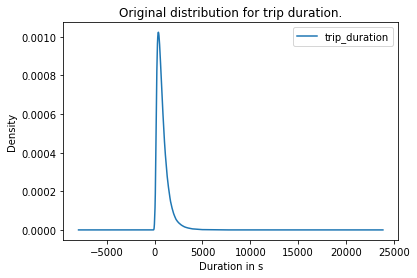

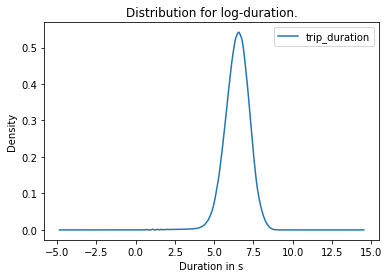

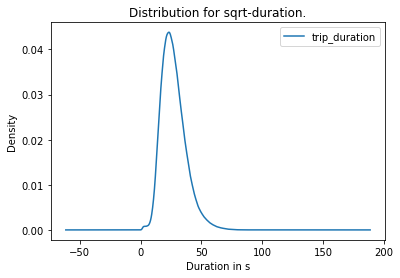

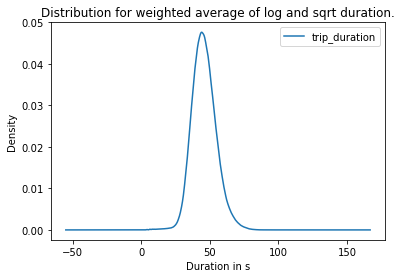

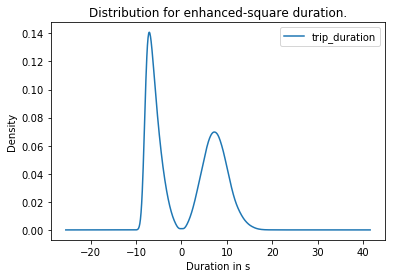

In [21]:
median = np.asscalar(y[second_index].median())

def enhancedCubicRootTransform(x, median):
    centered_val = x-median
    return np.sign(centered_val)*np.power(np.abs(centered_val), 1/3)

def inverseCubicRootTransform(z, median):
    return np.sign(z)*np.power(np.sign(z)*z, 3) + median

def doubleMeanTransform(vector):
    return list(map(lambda x: enhancedCubicRootTransform(x, median), vector))

def invDoubleMeanTransform(vector):
    return list(map(lambda z: inverseCubicRootTransform(z, median), vector))

def logTransform(vector):
    """Retrun logarithmic transform."""
    return list(map(np.log, vector))


def invLogTransform(vector):
    """Return the inverse log transform."""
    return list(map(np.exp, vector))


# Duration
y[second_index].plot(kind="kde")
plt.title('Original distribution for trip duration.')
plt.xlabel('Duration in s')
plt.show()

# Log-Duration
y[second_index].apply(lambda x: np.log(x)).plot(kind="kde")
plt.title('Distribution for log-duration.')
plt.xlabel('Duration in s')
plt.show()

# Sqrt-Duration
y[second_index].apply(lambda x: np.sqrt(x)).plot(kind="kde")
plt.title('Distribution for sqrt-duration.')
plt.xlabel('Duration in s')
plt.show()

# Weighted average of log and sqrt duration
y[second_index].apply(lambda x: (np.sqrt(x) + 10*np.log(x )) / 2).plot(kind="kde")
plt.title('Distribution for weighted average of log and sqrt duration.')
plt.xlabel('Duration in s')
plt.show()

# Enhanced-cubic-root
y[second_index].apply(lambda x: enhancedCubicRootTransform(x, median)).plot(kind="kde")
plt.title('Distribution for enhanced-square duration.')
plt.xlabel('Duration in s')
plt.show()

## Create Dataset

In [20]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [22]:
relevant_cols = ["distance", "log_distance", "hour", "passenger_count"] + weekdays + \
                ["cluster_" + str(i) for i in range(100)] + \
                [ "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude",'distance_to_center']
class_cols = [1, 1, 1] + [0 for i in weekdays] + [0 for i in range(100)] + \
             [1, 1, 1, 1, 1]

In [ ]:
def enhance(df, hasOutput=True):
    """Enhance datasets."""
    df = addDistance(df)
    df = addWeekday(df)
    df = addHour(df)
    df = addLatLngClusters(df)
    if hasOutput:
        df["log_duration"] = logTrasnf(df.trip_duration.values)
    return df

In [ ]:
enhanced_train = enhance(train[_index][second_index], True).dropna()

In [22]:
input_data = enhanced_train[relevant_cols]
output_data = enhanced_train[["log_duration"]]

In [27]:
input_data.columns

Index(['distance', 'log_distance', 'hour', 'passenger_count', 'monday',
       'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
       ...
       'cluster_95', 'cluster_96', 'cluster_97', 'cluster_98', 'cluster_99',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'distance_to_center'],
      dtype='object', length=116)

In [ ]:
normalize_method = "minmax"
transf = {'log_distance': lambda x: x ** 7}
dataset = mx.dataHandler.Dataset(input_data, output_data,
            normalize=normalize_method,
            datatypes={"input_data": class_cols, "output_data": [1]},
            apply=transf)


In [93]:
rf = RandomForestRegressor(n_estimators=10)

In [ ]:
#df = pd.DataFrame(dataset.norm_input_data)
#df.columns = relevant_cols
#df.columns

In [164]:
df_output = pd.DataFrame(dataset.norm_output_data)
df_output.columns = ["y"]
# 'distance': lambda x: np.sqrt(x)

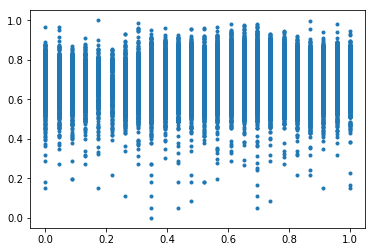

In [165]:
plt.plot(df.hour.apply(lambda x: x), df_output.y, '.')
plt.show()

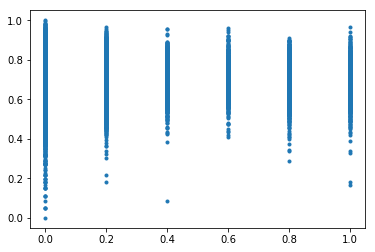

In [304]:
plt.plot(df.passenger_count.apply(lambda x: x), df_output.y, '.')
plt.show()

In [ ]:
plt.plot(df.log_distance.apply(lambda x: x ** (1/7)), df_output.y, '.')
plt.show()

### Random Forest

In [315]:
rff = RandomForestRegressor(n_estimators=100)

In [316]:
rf_x_train, rf_y_train = dataset.train
rf_x_test, rf_y_test = dataset.test
rff.fit(rf_x_train, rf_y_train.reshape((len(rf_y_train),)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [317]:

randomforest_train_estimates = rff.predict(rf_x_train)
randomforest_test_estimates = rff.predict(rf_x_test)

In [318]:
rff_errors = [i - j for i,j in zip(rf_y_train, randomforest_train_estimates)]

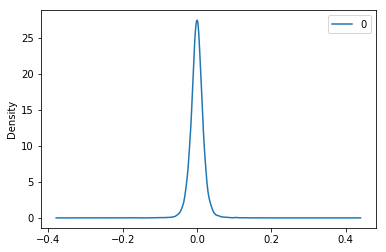

In [319]:
pd.DataFrame(rff_errors).plot(kind="kde")
plt.show()

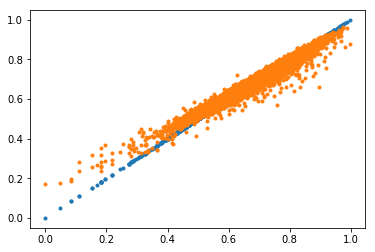

In [320]:
plt.plot(rf_y_train, rf_y_train, '.')
plt.plot(rf_y_train, randomforest_train_estimates, '.')
plt.show()

In [321]:
desnorm_train_y = np.array([desnormalize(np.asscalar(i), dataset, normalize_method) for i in rf_y_train])
desnorm_train_yest = np.array([desnormalize(i, dataset, normalize_method) for i in randomforest_train_estimates])

rmsle(invLogTransf(desnorm_train_yest), invLogTransf(desnorm_train_y))

0.15111691273792421

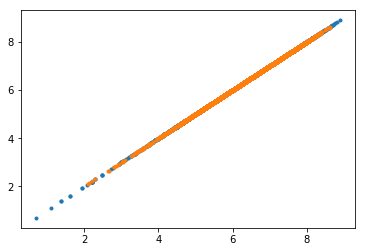

In [322]:
plt.plot(desnorm_train_y, desnorm_train_y, '.')
plt.plot(desnorm_train_yest, desnorm_train_yest, '.')
plt.show()

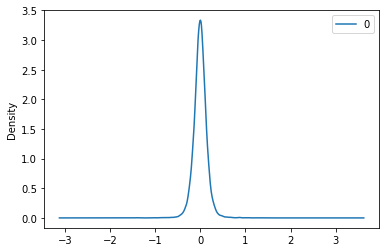

In [323]:
pd.DataFrame(desnorm_train_y-desnorm_train_yest).plot(kind="kde")
plt.show()

In [ ]:
test_data = enhance(pd.read_csv("data/test.csv"), False)

In [186]:
data = test_data[relevant_cols].apply(
                                lambda x: normalizeExternalData(x, dataset, normalize_method), 1)

In [187]:
for col in transf:
    data[col] = data[col].apply(transf[col]).values

In [188]:
vals = rff.predict(data)

In [189]:
    desnorm_vals = np.array([desnormalize(i, dataset, normalize_method) for i in vals]) 
    submit = pd.DataFrame({"id": test_data["id"].values,
                          "trip_duration": invLogTransf(desnorm_vals)})
    submit.to_csv("submit.csv", index=False)

In [394]:
input_data.shape

(28552, 115)

### Neural Nets

In [ ]:
# [50]*5 o [100]*3
_hdl = [50]*5
_epochs = 1000
mlp = mx.neuralNets.mlpRegressor(hidden_layers=_hdl, activation_function = 'relu')
mlp.train(dataset=dataset, alpha=0.01, epochs=_epochs)

In [418]:
mlp.activation

['sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', 'sigmoid', '']

In [414]:
train_res = pd.DataFrame(mlp.train_results)
test_res = pd.DataFrame(mlp.test(dataset=dataset))

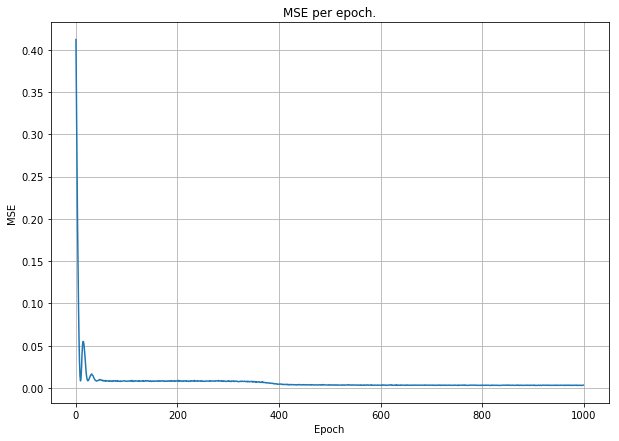

In [415]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(_epochs), mlp.epoch_error)
plt.title("MSE per epoch.")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.show()

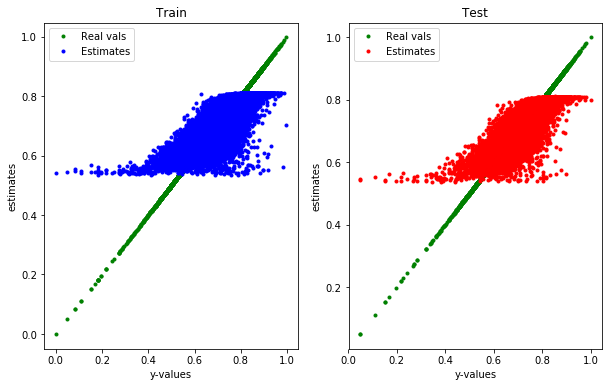

In [416]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
plt.subplot(121)
plt.plot(train_res.y, train_res.y, ".g", label="Real vals")
plt.plot(train_res.y, train_res.estimates, ".b", label="Estimates")
plt.title("Train")
plt.xlabel("y-values")
plt.ylabel("estimates")
plt.legend()
plt.subplot(122)
plt.plot(test_res.y, test_res.y, ".g", label="Real vals")
plt.plot(test_res.y, test_res.estimates, ".r", label="Estimates")
plt.title("Test")
plt.xlabel("y-values")
plt.ylabel("estimates")
plt.legend()
plt.show()

In [329]:
rf = RandomForestRegressor(n_estimators=20)

In [330]:
forest_x, forest_y = dataset.train
forest_x_test, forest_y_test = dataset.test
rf.fit(forest_x, train_res.errors.values)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [331]:
trust_in_rf = 5

In [347]:
desnorm_train_y = np.array([desnormalize(np.asscalar(i), dataset, normalize_method) for i in train_res.y])
desnorm_train_yest = np.array([desnormalize(i, dataset, normalize_method) for i in train_res.estimates])

desnorm_test_y = np.array([desnormalize(np.asscalar(i), dataset, normalize_method) for i in test_res.y])
desnorm_test_yest = np.array([desnormalize(i, dataset, normalize_method) for i in test_res.estimates])


def getTrainRMSE(trust_in_rf):
    return rmsle(invLogTransf(desnorm_train_yest + trust_in_rf*rf.predict(forest_x)), invLogTransf(desnorm_train_y))


def getTestRMSE(trust_in_rf):
    return rmsle(invLogTransf(desnorm_test_yest + trust_in_rf*rf.predict(forest_x_test)), invLogTransf(desnorm_test_y))

print(getTrainRMSE(trust_in_rf))
print(getTestRMSE(trust_in_rf))

0.192474201897
0.397363634156


In [336]:
rmses = []
for tr in range(30):
    temp = getTestRMSE(tr)
    rmses.append(temp)
    print(temp)

0.468067007647
0.451348387773
0.43652430786
0.423794195547
0.413351976551
0.405374741629
0.400010060252
0.397363634156
0.397489425469
0.400384262967
0.40598812187
0.41419001251
0.42483817867
0.437752559835
0.452737405743
0.469592414338
0.488121486905
0.508138867467
0.529472899709
0.551967868517
0.575484447319
0.599899220171
0.62510365038
0.65100276489
0.677513735233
0.70456446833
0.732092272894
0.760042635827
0.788368123317
0.817027409243


In [337]:
trust_in_rf = np.argmin(rmses)
trust_in_rf

7

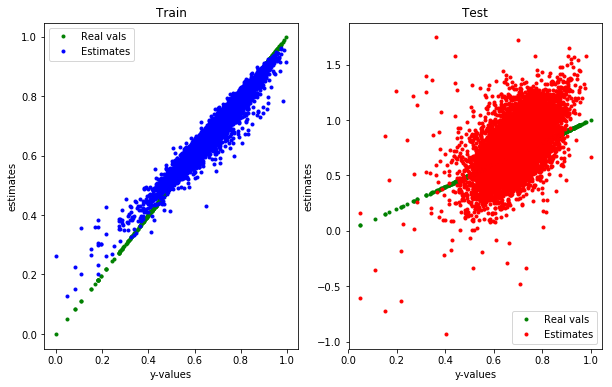

In [338]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
plt.subplot(121)
plt.plot(train_res.y, train_res.y, ".g", label="Real vals")
plt.plot(train_res.y, train_res.estimates + rf.predict(forest_x), ".b", label="Estimates")
plt.title("Train")
plt.xlabel("y-values")
plt.ylabel("estimates")
plt.legend()
plt.subplot(122)
plt.plot(test_res.y, test_res.y, ".g", label="Real vals")
plt.plot(test_res.y, test_res.estimates + trust_in_rf * rf.predict(forest_x_test), ".r", label="Estimates")
plt.title("Test")
plt.xlabel("y-values")
plt.ylabel("estimates")
plt.legend()
plt.show()

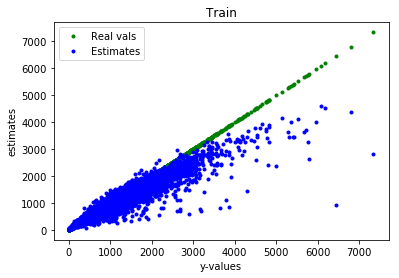

In [339]:
plt.plot(invLogTransf(desnorm_train_y), invLogTransf(desnorm_train_y), ".g", label="Real vals")
plt.plot(invLogTransf(desnorm_train_y), (invLogTransf(desnorm_train_yest + trust_in_rf*rf.predict(forest_x))), ".b", label="Estimates")
plt.title("Train")
plt.xlabel("y-values")
plt.ylabel("estimates")
plt.legend()
plt.show()

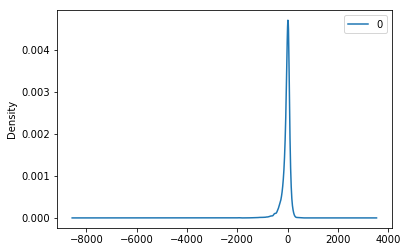

In [346]:
tr_error = [i-j for i,j in zip(invLogTransf(desnorm_train_yest + trust_in_rf*rf.predict(forest_x)), invLogTransf(desnorm_train_y))]
pd.DataFrame(tr_error).plot(kind="kde")
plt.show()

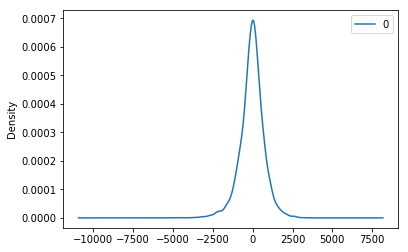

In [345]:
tr_error = [i-j for i,j in zip(invLogTransf(desnorm_test_yest + trust_in_rf*rf.predict(forest_x_test)), invLogTransf(desnorm_train_y))]
pd.DataFrame(tr_error).plot(kind="kde")
plt.show()

In [66]:
def createSubmissionFile():
    test_data = enhance(pd.read_csv("data/test.csv"), False)
    data = test_data[relevant_cols].apply(
                                lambda x: normalizeExternalData(x, dataset, normalize_method), 1)
    forest_adjust = rf.predict(data)
    vals = mlp.freeEval(data)
    desnorm_vals = np.array([desnormalize(i, dataset, normalize_method) for i in vals]) + forest_adjust
    submit = pd.DataFrame({"id": test_data["id"].values,
                          "trip_duration": invLogTransf(desnorm_vals)})
    submit.to_csv("submit.csv", index=False)
    return True

In [67]:
createSubmissionFile()

True

In [23]:
test_data = enhance(pd.read_csv("data/test.csv"), False)

In [ ]:
data = test_data[relevant_cols].apply(
                    lambda x: normalizeExternalData(x, dataset, normalize_method), 1)

In [351]:
for col in transf:
    data[col] = data[col].apply(transf[col]).values

In [352]:
forest_adjust = rf.predict(data)

In [353]:
vals = mlp.freeEval(data)

In [354]:
desnorm_vals = np.array([desnormalize(i, dataset, normalize_method) for i in vals]) + trust_in_rf*forest_adjust

In [355]:
submit = pd.DataFrame({"id": test_data["id"].values,
                         "trip_duration": invLogTransf(desnorm_vals)})

In [356]:
submit.to_csv("submit.csv", index=False)

In [191]:
submit

,id,trip_duration
0,id3004672,904.347478
1,id3505355,650.216067
2,id1217141,321.654405
3,id2150126,1138.430292
4,id1598245,371.079382
5,id0668992,821.271730
6,id1765014,760.082828
7,id0898117,1013.699997
8,id3905224,1859.497927
9,id1543102,562.000365


## Linear Regression Estimate

In [70]:
coefs = getCoefs(pd.DataFrame(dataset.input_data, dtype='float'),
                 pd.DataFrame(dataset.output_data, dtype='float'))

In [71]:
yest_train = liniarReg(pd.DataFrame(dataset.input_data, dtype='float'))

In [72]:
desnorm_train_y = np.array([desnormalize(i, dataset, normalize_method) for i in pd.DataFrame(dataset.norm_output_data, dtype='float').values])
desnorm_train_yest = np.array([desnormalize(i, dataset, normalize_method) for i in yest_train])

desnorm_trainestim_y = np.array([desnormalize(i, dataset, normalize_method)
                                 for i in yest_train])


rmsle(invLogTransf(desnorm_train_yest), invLogTransf(desnorm_train_y))

/home/rhdzmota/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: overflow encountered in exp


inf

In [89]:
linReg = lambda x: np.asscalar(liniarReg(pd.DataFrame(x, dtype='float').T)) 

In [81]:
rmsle([np.asscalar(i) if np.asscalar(i) > 0 else 0.0000001 for i in yest_train], [np.asscalar(i) for i in dataset.output_data])

2.9437706147458127

In [80]:
dataset.output_data

array([[ 6.12029742],
       [ 6.49677499],
       [ 7.66105638],
       ..., 
       [ 6.2126061 ],
       [ 7.11232744],
       [ 6.15697899]])

In [147]:
y[second_index].iloc[0] - np.asscalar(y[second_index].median())

trip_duration   -192.0
Name: 0, dtype: float64

In [86]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

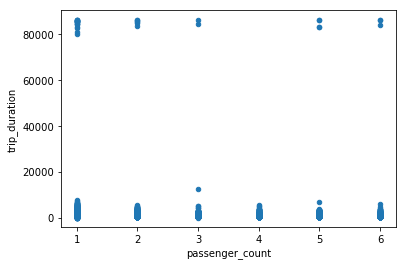

In [87]:
train[_index].plot.scatter("passenger_count", "trip_duration")
plt.show()